# Heat transfer for Extended surfaces

Fins are widely used to increase heat transfer through an increase of the surface area exposed to convection and radiation heat transfer. The following shows the comparison between theory and (an almost realistic) simulation of a rectangular fin subjected to a convection flow, with characteristics $h$ and $T_\infty$. The fin material has a conductivity of $k$ assumed to be constant for the range of temperature of our problem

The theory starts with the geometry of the fin. Here we consider the simplest case, a rectangular thin. The cross-sectional area is $A_c=wt$, where $w$ is the width and $t$ the tickness. The perimeter of this area is $P=2(w+t)$. The length is $L$. 

A control volume between $x$ and $x+\Delta x$ and bounded from the whole of cross sectional area $A_c$. If one assumes on any cross-sectional area temperature variation to be negligible, the problem reduces to the following ODE (derived in great details in your book).
$$
\frac{d^2T}{dx^2}-\frac{hP}{kA_c}\left(T(x)-T_\infty\right)=0
$$
and by operating the variable transformation $\theta(x)=\left(T(x)-T_\infty\right)$:
$$
\frac{d^2\theta}{dx^2}-m^2\theta=0 \text{ with }m^2=\frac{hP}{kA_c}
$$
The general solution is
$$
\theta(x)=C_1e^{+mx}+C_2e^{-mx}
$$
The constants are determined by the boundary conditions at
<ul>
<li> $x=0$. Here we assume constant base temperature $T_b$ or $\theta_b=T_b-T_\infty$
$$
\theta_b=C_1+C_2
$$</li>
<li> $x=L$. The solution for this boundary depends on the approximation we think we can make:
<ul>
<li> Convection flow
$$
h\theta(L)=-k\left.\frac{d\theta}{dx}\right\vert_{x=L}
$$
</li>
<li> Adiabatic
$$
\left.\frac{d\theta}{dx}\right\vert_{x=L}=0
$$
</li>
<li> Constant temperature
$$
\theta(L)=T_L-T_\infty
$$
</li>
<li> Infinite fin ($L/t\gg 1$?)
$$
\theta(L)=0
$$
</li>
</ul>
</li>
</ul>

In [1]:
%matplotlib inline 


from IPython.display import clear_output

import schemdraw as schem
import schemdraw.elements as e

import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.constants as sc

import sympy as sym




## Discretized heat equation for steady, pure conduction

Under the assumption of constant thermodynamic properties, the heat transport equation can be derived as:
$$
\rho C_p\left(\frac{\partial T}{\partial t}+\mathbf{u}.\boldsymbol{\nabla}T\right)=k\nabla^2T
$$
For a pure conduction (velocity vector $\mathbf{u}=\mathbf{0}$) and steady state $\partial T/\partial t=0$, the temperature field is the solution of:
$$
\nabla^2 T=0\Leftrightarrow \frac{\partial^2 T}{\partial x^2}+\frac{\partial^2 T}{\partial y^2}+\frac{\partial^2 T}{\partial z^2}=0
$$

This equation can be derived by using a 2D control volume of dimensions $\Delta x\times\Delta y$ and applying the conservation of energy and Fourier's law on the surface of the control volume.

Show that:

$$
\frac{k\Delta y}{\Delta x}\left(T_{i,j}-T_{i-1,j}\right)
-\frac{k\Delta y}{\Delta x}\left(T_{i+1,j}-T_{i,j}\right)
+\frac{k\Delta x}{\Delta y}\left(T_{i,j}-T_{i,j-1}\right)
-\frac{k\Delta x}{\Delta y}\left(T_{i,j+1}-T_{i,j}\right)=0
$$


Using Taylor series expansion, show that:
$$
\frac{\partial^2 T}{\partial x^2}=\frac{T_{i+1,j} - 2T_{i,j} + T_{i-1,j}}{\Delta x^2}
$$
and then show
$$
-\frac{k\Delta x}{\Delta y}T_{i,j-1}
-\frac{k\Delta x}{\Delta y}T_{i-1,j}
+\left(2\frac{k\Delta x}{\Delta y}+2\frac{k\Delta y}{\Delta x}\right)T_{i,j}
-\frac{k\Delta x}{\Delta y}T_{i+1,j}
-\frac{k\Delta x}{\Delta y}T_{i,j+1}=0
$$
$$
\Leftrightarrow\frac{\partial^2 T}{\partial x^2}+\frac{\partial^2 T}{\partial y^2}=0
$$

In [2]:
def build_matrix(n,A,b,nx,ny,dx,dy,k_cond,h,alpha,beta,T_infty,Tiso):
    for j in range (1,ny-1):
        for i in range (1,nx-1):
            k = i + j * nx
            kim = k - 1
            kip = k + 1
            kjm = k - nx
            kjp = k + nx
            A[k, k] = k_cond*(2.*dx/dy+2.*dy/dx) 
            A[k, kim] = -k_cond*dy/dx
            A[k, kip] = -k_cond*dy/dx
            A[k, kjm] = -k_cond*dx/dy
            A[k, kjp] = -k_cond*dx/dy
            
    i = 0 
    j = 0
    k = i + j * nx
    kip = 1
    kjp = nx
    A[k,k] = 3.*k_cond*dy/dx+k_cond*dx/dy+alpha*h*dx
    A[k,kip] = -k_cond*dy/dx
    A[k,kjp] = -k_cond*dx/dy+beta*h*dx
    b[k] = 2.*k_cond*dy/dx*T_iso+h*dx*T_infty
    
    i = 0
    j = ny-1
    k = i + j * nx
    kim = k - 1
    kip = k + 1
    kjm = k - nx
    kjp = k + nx

    A[k,kjm] = -k_cond*dx/dy + beta*h*dx
    A[k,k] = 3.*k_cond*dy/dx+k_cond*dx/dy + alpha*h*dx
    A[k,kip] = -k_cond*dy/dx
    b[k] = 2.*k_cond*dy/dx*T_iso + h*dx*T_infty
    
    i = 0
    for j in range (1,ny-1):
        k = i + j * nx
        kim = k - 1
        kip = k + 1
        kjm = k - nx
        kjp = k + nx
        A[k,kjm] = -k_cond*dx/dy
        A[k,k] = 3.*k_cond*dy/dx+2.*k_cond*dx/dy
        A[k,kip] = -k_cond*dy/dx
        A[k,kjp] = -k_cond*dx/dy
        b[k] = 2.*k_cond*dy/dx*T_iso
        
    i = nx-1
    j = 0
    k = i + j * nx
    kim = k - 1
    kip = k + 1
    kjm = k - nx
    kjp = k + nx
    A[k,kim] = -k_cond*dy/dx+beta*h*dy
    A[k,k] = k_cond*dy/dx+k_cond*dx/dy+alpha*h*dy
    A[k,kjp] = -k_cond*dx/dy
    b[k] = +h*dy*T_infty
    
    i = nx-1
    j = ny-1
    k = i + j * nx
    kim = k - 1
    kip = k + 1
    kjm = k - nx
    kjp = k + nx
    A[k,kjm] = -k_cond*dx/dy
    A[k,kim] = -k_cond*dy/dx+beta*h*dy
    A[k,k] = k_cond*dy/dx+k_cond*dx/dy+alpha*h*dy
    b[k] = h*dy*T_infty
    
    i = nx-1
    for j in range (1,ny-1):
        k = i + j * nx
        kim = k - 1
        kip = k + 1
        kjm = k - nx
        kjp = k + nx
        A[k,kjm] = -k_cond*dx/dy
        A[k,kim] = -k_cond*dy/dx + beta*h*dy
        A[k,k] = k_cond*dy/dx+2.*k_cond*dx/dy + alpha*h*dy
        A[k,kjp] = -k_cond*dx/dy
        b[k] = h*dy*T_infty
        
    j = 0
    for i in range (1,nx-1):
        k = i + j * nx
        kim = k - 1
        kip = k + 1
        kjm = k - nx
        kjp = k + nx
        A[k,kim] = -k_cond*dy/dx
        A[k,k] = 2.*k_cond*dy/dx+k_cond*dx/dy + alpha*h*dx
        A[k,kip] = -k_cond*dy/dx
        A[k,kjp] = -k_cond*dx/dy + beta*h*dx
        b[k] = h*dx*T_infty
        
    j = ny-1
    for i in range (1,nx-1):
        k = i + j * nx
        kim = k - 1
        kip = k + 1
        kjm = k - nx
        kjp = k + nx
        A[k,kjm] = -k_cond*dx/dy+beta*h*dx
        A[k,kim] = -k_cond*dy/dx
        A[k,k] = 2.*k_cond*dy/dx+k_cond*dx/dy+alpha*h*dx
        A[k,kip] = -k_cond*dy/dx
        b[k] = h*dx*T_infty
    

A major difficulty of this code resides in the rearrangement of the matrix $T_{i,j}$ into the vector $T_k$ with $k=i+j.nx$. The matrix is now pentadiagonal with its two furthest diagonal at $\pm nx$ from the main diagonal

Boundary condition: Isothermal at the base, convection everywhere else.
$i=0,j=0$:
$$
k\frac{T_{0,0}-T_a}{\Delta x/2}\Delta y-k\frac{T_{1,0}-T_{0,0}}{\Delta x}\Delta y+h\Delta x\left(\alpha T_{0,0}+\beta T_{0,1}-T\infty\right)-k\frac{T_{0,1}-T_{0,0}}{\Delta y}\Delta x = 0
$$

$$\left(3\frac{k\Delta y}{\Delta x}+k\frac{\Delta x}{\Delta y}+\alpha h \Delta x\right)T_{0,0}
-\frac{k\Delta y}{\Delta x}T_{1,0}
+\left(-\frac{k\Delta x}{\Delta y}+\beta h \Delta x\right)T_{0,1}
=2\frac{k\Delta y}{\Delta x}T_a+h\Delta x T_\infty
$$

$i=0,j=ny-1$:
$$
k\frac{T_{0,ny-1}-T_a}{\Delta x/2}\Delta y-k\frac{T_{1,ny-1}-T_{0,ny-1}}{\Delta x}\Delta y +k\frac{T_{0,ny-1}-T_{0,ny-2}}{\Delta y}\Delta x +h\Delta x\left(\alpha T_{0,ny-1}+\beta T_{0,ny-2}-T_\infty\right) = 0
$$

$$
\left(-\frac{k\Delta x}{\Delta y}+\beta h\Delta x\right)T_{0,ny-2}+\left(3\frac{k\Delta y}{\Delta x}T+\frac{k\Delta x}{\Delta y}+\alpha h\Delta x\right)T_{0,ny-1}-\frac{k\Delta y}{\Delta x}T_{1,ny-1}=2\frac{k\Delta y}{\Delta x}T_a + h\Delta x T_\infty
$$

$i=0,j\in\left]0,ny-1\right[$:
$$
k\frac{T_{0,j}-T_a}{\Delta x/2}\Delta y-k\frac{T_{1,j}-T_{0,j}}{\Delta x}\Delta y +k\frac{T_{0,j}-T_{0,j-1}}{\Delta y}\Delta x -k\frac{T_{0,j+1}-T_{0,j}}{\Delta y}\Delta x = 0
$$

$$
-\frac{k\Delta x}{\Delta y}T_{0,j-1}
+\left(3\frac{k\Delta y}{\Delta x}+2\frac{k\Delta x}{\Delta y}\right)T_{0,j}
-\frac{k\Delta y}{\Delta x}T_{1,j}
-\frac{k\Delta x}{\Delta y}T_{0,j+1}=2\frac{k\Delta y}{\Delta x}T_a
$$

$i=nx-1,j=0$:
$$
k\frac{T_{nx-1,0}-T_{nx-2,0}}{\Delta x}\Delta y-h\Delta y\left(\alpha T_{nx-1,0}+\beta T_{nx-2,0}-T_\infty\right)-k\frac{T_{nx-1,1}-T_{nx-1,0}}{\Delta y}\Delta x = 0
$$

$$
\left(-\frac{k\Delta y}{\Delta x}-\beta h \Delta y\right)T_{nx-2,0}+
\left(\frac{k\Delta y}{\Delta x}+k\frac{\Delta x}{\Delta y}-\alpha h \Delta y\right)T_{nx-1,0}-\frac{k\Delta x}{\Delta y}T_{nx-1,1}=-h\Delta y T_\infty
$$

$i=nx-1,j=ny-1$:
$$
k\frac{T_{nx-1,ny-1}-T_{nx-2,ny-1}}{\Delta x}\Delta y+h\Delta y\left(\alpha T_{nx-1,ny-1}+\beta T_{nx-2,ny-1}-T_\infty\right)+k\frac{T_{nx-1,ny-1}-T_{nx-1,ny-2}}{\Delta y}\Delta x = 0
$$

$$
-\frac{k\Delta x}{\Delta y}T_{nx-1,ny-2}
+\left(-\frac{k\Delta y}{\Delta x}+\beta h\Delta y\right)T_{nx-2,ny-1}+
\left(\frac{k\Delta y}{\Delta x}+k\frac{\Delta x}{\Delta y}+\alpha h \Delta y\right)T_{nx-1,ny-1}
=h\Delta yT_\infty
$$

$i=nx-1,j\in\left]0,ny-1\right[$:
$$
k\frac{T_{nx-1,j}-T_{nx-2,j}}{\Delta x}\Delta y+h\Delta y\left(\alpha T_{nx-1,j}+\beta T_{nx-2,j}-T_\infty\right)
+k\frac{T_{nx-1,j}-T_{nx-1,j-1}}{\Delta y}\Delta x-k\frac{T_{nx-1,j+1}-T_{nx-1,j}}{\Delta y}\Delta x = 0
$$

$$
-\frac{k\Delta x}{\Delta y}T_{nx-1,j-1}
+\left(-\frac{k\Delta y}{\Delta x}+\beta h \Delta y\right)T_{nx-2,j}+
\left(\frac{k\Delta y}{\Delta x}+2k\frac{\Delta x}{\Delta y}+\alpha h \Delta y\right)T_{nx-1,j}-\frac{k\Delta x}{\Delta y}T_{nx-1,j+1}=h\Delta y T_\infty
$$

$0<i<nx-1,j=0$:
$$
k\frac{T_{i,0}-T_{i-1,0}}{\Delta x}\Delta y-k\frac{T_{i+1,0}-T_{i,0}}{\Delta x}\Delta y
+h\Delta x\left(\alpha T_{i,0}+\beta T_{i,1}-T_\infty\right)-k\frac{T_{i,1}-T_{i,0}}{\Delta y}\Delta x = 0
$$

$$
-\frac{k\Delta y}{\Delta x}T_{i-1,0}+\left(2\frac{k\Delta y}{\Delta x}+\frac{k\Delta x}{\Delta y}+\alpha h \Delta x\right)T_{i,0}
-\frac{k\Delta y}{\Delta x}T_{i+1,0}
+\left(-\frac{k\Delta x}{\Delta y}+\beta h\Delta x\right)T_{i,1} = h\Delta x T_\infty
$$

$0<i<nx-1,j=ny-1$:
$$
k\frac{T_{i,ny-1}-T_{i-1,ny-1}}{\Delta x}\Delta y-k\frac{T_{i+1,ny-1}-T_{i,ny-1}}{\Delta x}\Delta y +k\frac{T_{i,ny-1}-T_{i,ny-2}}{\Delta y}\Delta x +h\Delta x\left(\alpha T_{i,ny-1}+\beta T_{i,ny-2}-T_\infty\right) = 0
$$

$$
\left(-\frac{k\Delta x}{\Delta y}+\beta h\Delta x\right)T_{i,ny-2}-\frac{k\Delta y}{\Delta x}T_{i-1,ny-1}+\left(2\frac{k\Delta y}{\Delta x}+\frac{k\Delta x}{\Delta y}+\alpha h \Delta x\right)T_{i,ny-1}-\frac{k\Delta y}{\Delta x}T_{i+1,ny-1} = h\Delta x T_\infty
$$

In [3]:
def fin(k_cond,T_iso,T_infty,h,lx,ly,nx,ny):
    
    dx = lx/(nx)
    dy = ly/(ny)
    n = nx*ny
    alpha = 3./2.
    beta = -1./2.
    t = ly
    w = 1 #m 
    A_c = t*w
    P = 2.*(t+w)
    m = np.sqrt(h*P/(k_cond*A_c))
    L = lx
    theta_b = T_iso - T_infty

    A = np.zeros((n,n), dtype = np.float)
    b = np.zeros((n,1), dtype = np.float)
    Tn = np.zeros((nx,ny), dtype = np.float)
    theta_comp = np.zeros((nx,ny))
    theta_conv = np.zeros(nx)
    theta_inf = np.zeros(nx)
    Xn = np.zeros((nx,ny), dtype = np.float)
    Yn = np.zeros((nx,ny), dtype = np.float)

    x = np.array([(i+0.5)*dx for i in range(nx)])
    y = np.array([(j+0.5)*dy for j in range(ny)])

    for j in range (ny):
        for i in range (nx):
            Xn[i,j] = x[i]
            Yn[i,j] = y[j]

    build_matrix(n,A,b,nx,ny,dx,dy,k_cond,h,alpha,beta,T_infty,T_iso)


    T = np.linalg.solve(A, b)


    i = 0
    j = 0
    for k in range (n):
        i = k - j*nx
        if (i > nx-1):
            j += 1
            i = 0
        Tn[i,j] = T[k]
        theta_comp[i,j] = Tn[i,j] - T_infty

    for i in range (nx):
        # Temperature distribution for an infinite fin
        theta_inf[i] = np.exp(-m*x[i])
        # Temperature for convection boundary condition at the tip
        theta_conv[i] = (np.cosh(m*(L-x[i]))+(h/(m*k_cond))*np.sinh(m*(L-x[i]))) \
                        /(np.cosh(m*L)+(h/(m*k_cond))*np.sinh(m*L))
    theta_conv *= theta_b 
    theta_inf *= theta_b
    return x,y,dx,dy,Xn,Yn,Tn,theta_comp,theta_conv,theta_inf,m*L

In [9]:
import numpy as np
##############################
#        Parameters          #
##############################
k_cond = 180.
nx = 100
ny = 20

lx = 0.01
ly = 0.005



n = nx*ny

T_iso = 100.
T_infty = 25.
h = 100. #W/m^2.K



x,y,dx,dy,Xn,Yn,Tn,theta_comp,theta_conv,theta_inf,mL = \
        fin(k_cond,T_iso,T_infty,h,lx,ly,nx,ny)



heat rate= 183.9 W/m
mL= 0.149


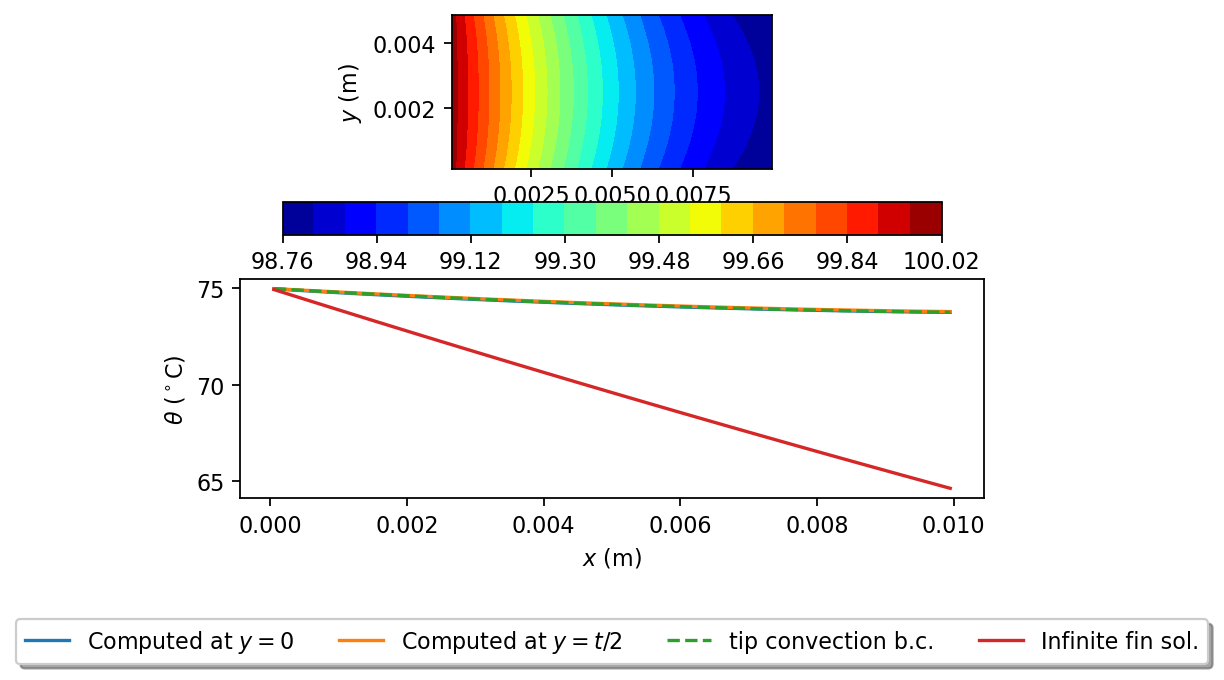

In [10]:
fig = plt.figure(num=None, figsize=(6, 4), dpi=160, facecolor='w', edgecolor='k')
ax = fig.add_subplot(211)
im = ax.contourf(Xn, Yn, Tn, 20, cmap='jet')
ax.set_aspect('equal')
#ax.set_xlabel('$x$ (m)')
ax.set_ylabel('$y$ (m)')
fig.colorbar(im, ax = ax, orientation = 'horizontal')
bx = fig.add_subplot(212)
bx.plot(x, theta_comp[:,0], label='Computed at $y=0$')
bx.plot(x, theta_comp[:,ny//2], label='Computed at $y=t/2$')
bx.plot(x, theta_conv,'--', label='tip convection b.c.')
bx.plot(x, theta_inf,'-', label='Infinite fin sol.')
bx.set_xlabel('$x$ (m)')
bx.set_ylabel(r'$\theta$ ($^\circ$C)')
bx.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5),
          fancybox=True, shadow=True, ncol=5)

heat_rate = 0.


heat_rate = np.sum(-k_cond*(Tn[0,:]-T_iso)/(dx/2.)*dy)
print('heat rate= %4.1f W/m' %heat_rate)
print('mL= %2.3f' %mL)

In [14]:
print('error:',np.mean(theta_comp[-1,:])/T_infty)

error: 0.09950832845317478
